<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day 20: Mutual Information/Registration"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 20, March 20, 2018</h4>

In [1]:
import SimpleITK as sitk

import matplotlib.pyplot as plt
%matplotlib inline 

%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import gui
import registration_gui as rgui
%matplotlib notebook

import numpy as np
import os
OUTPUT_DIR = 'output'

In [2]:
# let us read an image and take a closer look at it:

# the fixed image, read the file and store it as sitkFloat32
fixedImage = sitk.ReadImage('BrainProtonDensitySliceBorder20.png', sitk.sitkFloat32 )
# the moving image, read the file and store it as sitkFloat32
movingImage = sitk.ReadImage('BrainProtonDensitySliceR10X13Y17.png', sitk.sitkFloat32 )

In [3]:
# define an utility function to display 2 2D images side-by-side

def display_2D_Images( fixed_npa, moving_npa ):
    # create a figure with two subplots and the specified size
    plt.subplots( 1, 2, figsize=( 10, 8 ) )
    
    # draw the fixed image in the first (left) subplot
    plt.subplot( 1, 2, 1 )
    plt.imshow( sitk.GetArrayViewFromImage(fixed_npa), cmap=plt.cm.Greys_r )
    plt.title( 'Fixed Image' )
    plt.axis( 'off' )
    
    # draw the moving image in the second (right) subplot
    plt.subplot( 1, 2, 2 )
    plt.imshow( sitk.GetArrayViewFromImage(moving_npa), cmap=plt.cm.Greys_r )
    plt.title( 'Moving Image' )
    plt.axis( 'off' )
    
    plt.show()

#### Parameter turning

The options you set to each components of the optimization framework determins how well it work. Here, we turn parameters of the optimizer and registration framework that could affect the result.

* Metrics
  * The type of metric
  * Options for each metric. For example, the calculation of mutual information depends on the histogram bin width
  * The percentage of pixel/voxels used to compute the metric

In [4]:
# parameter tuning
registration_method = sitk.ImageRegistrationMethod()

#### Similarity metric settings,

We need to set the number of bins used in computing the joint histogram for the mutual information metric.

By default, the metric uses a randomly chosen subset of pixels to speed up the computation. It is possible to choose the size of this subset (and this affects the trade-off between speed and accuracy) but for this example, we will instruct the metric to use all of the pixels.

In [5]:
# Similarity metric settings,
registration_method.SetMetricAsMattesMutualInformation(50)
registration_method.SetMetricSamplingPercentage(1.0)

#### interpolator

In [6]:
# interpolator
registration_method.SetInterpolator( sitk.sitkLinear )

#### Optimizer setting

These lines of code set the maximum and minimum step lengths of the optimizer.

This optimizer will translate the moving image in the x- and y- directions by some amount, in the direction that best optimizes the image similarity metric.  The length of the steps that it takes, in this case, is $4$mm. But what if it overshoots the optimal transformation by taking such a big steps?

It detects this situation by noticing that it needs to reverse its direction after the overshoot. When it detects this situation, it cuts its step size in half, to $2$mm. Even at $2$mm, it may overshoot again, requirint yet another change in direction, at which point it will cut its step size in half again, to $1$mm.

This process continues with the optimizer oscillating back and forth over the optimal transformation, until eventually the step size becomes out specified minimum of $0.1$mm, at which point the optimizer stops and declares that it has found the answer.

In [7]:
# Optimizer setting
maxStep = 4.0
minStep = 0.1
numberOfIterations = 200
relaxationFactor = 0.5
registration_method.SetOptimizerAsRegularStepGradientDescent( maxStep, minStep, numberOfIterations, relaxationFactor )

We need to tell the optimizer roughly what we expect in terms of the amounts of rotation and translation between the two images. Supposing our guess is around $20$ degrees of rotation (0.35 radians) and $100$mm of translation in both directions, we would indicate that as follows:

In [8]:
# 1st option relates to rotation
registration_method.SetOptimizerScales( [1.0/0.35, 1.0/100.0, 1.0/100.0] )

#### Transform

Previously we were interesting in translation only. For a rigid-body rotation (Rotation and Translation), we can use Euler2DTransformation (or Euler3DTransformation)

In [9]:
# transform
#initial_transform = sitk.TranslationTransform( fixedImage.GetDimension() )
initial_transform = sitk.Euler2DTransform()

# We need to tell SimpleITK what point we want to use for the cetner of rotation.
# These images have 221 columns (along the x direction) and 257 rows (along the y direction).
# We want the center of rotation to be the center of the image.
initial_transform.SetCenter( [110.5, 128.5] )

#### connect the registration framework to the call backs we defined as to visualize the progress.

In [10]:
# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

0

#### Actions!

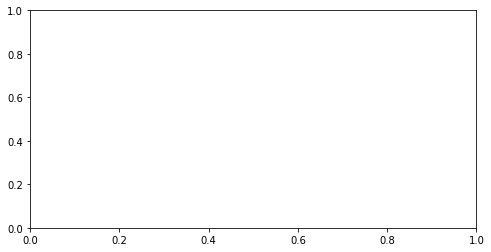

Final metric value: -0.8876393653681733
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 13 iterations. Current step (0.0625) is less than minimum step (0.1).


In [11]:
registration_method.SetInitialTransform( initial_transform )

final_transform = registration_method.Execute( fixedImage, movingImage )

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

#### Visualization

We can apply the transform we just computed to the

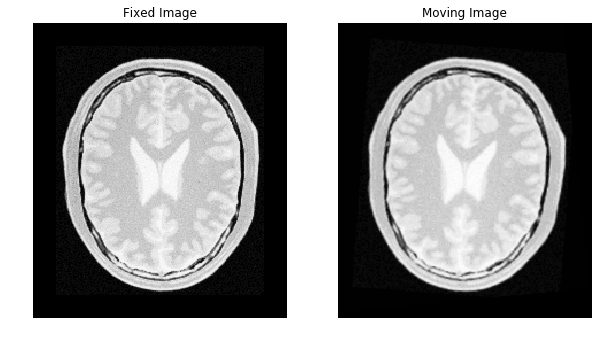

In [12]:
moving_resamples = sitk.Resample( movingImage, final_transform, sitk.sitkLinear, 0.0, movingImage.GetPixelID() )
display_2D_Images( fixedImage, moving_resamples )